In [1]:
#Import of librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
df_train = pd.read_csv('C:/Users/alexa/BigDataApplication_Project/data/external/application_train.csv')
df_test = pd.read_csv('C:/Users/alexa/BigDataApplication_Project/data/external/application_test.csv')

In [3]:
df_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Training data shape :",df_train.shape)
print("Testing data shape :",df_test.shape) #(one column less => Target to predict)

Training data shape : (307511, 122)
Testing data shape : (48744, 121)


<AxesSubplot:xlabel='TARGET', ylabel='count'>

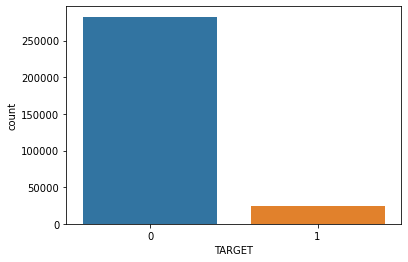

In [5]:
sns.countplot(x='TARGET',data=df_train)

##### TARGET : (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases).
##### Here, we see that, for the training set, only few persons weren't able to repay the depts

### 1. Data preparation

In [6]:
df_train.isnull().sum().sort_values(ascending=False)

COMMONAREA_MEDI                214865
COMMONAREA_AVG                 214865
COMMONAREA_MODE                214865
NONLIVINGAPARTMENTS_MODE       213514
NONLIVINGAPARTMENTS_MEDI       213514
                                ...  
REG_CITY_NOT_LIVE_CITY              0
LIVE_REGION_NOT_WORK_REGION         0
REG_REGION_NOT_WORK_REGION          0
HOUR_APPR_PROCESS_START             0
SK_ID_CURR                          0
Length: 122, dtype: int64

##### We observe that multiple features have a lot of missing values that we'll have to handle.

In [7]:
df_train_nan = (df_train.isnull().sum()/df_train.shape[0])*100
df_train_nan.sort_values(ascending=False)

COMMONAREA_MEDI                69.872297
COMMONAREA_AVG                 69.872297
COMMONAREA_MODE                69.872297
NONLIVINGAPARTMENTS_MODE       69.432963
NONLIVINGAPARTMENTS_MEDI       69.432963
                                 ...    
REG_CITY_NOT_LIVE_CITY          0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_REGION_NOT_WORK_REGION      0.000000
HOUR_APPR_PROCESS_START         0.000000
SK_ID_CURR                      0.000000
Length: 122, dtype: float64

In [8]:
df_test_nan = (df_test.isnull().sum()/df_test.shape[0])*100
df_test_nan.sort_values(ascending=False)

COMMONAREA_MEDI                68.716150
COMMONAREA_AVG                 68.716150
COMMONAREA_MODE                68.716150
NONLIVINGAPARTMENTS_MODE       68.412523
NONLIVINGAPARTMENTS_MEDI       68.412523
                                 ...    
REG_CITY_NOT_WORK_CITY          0.000000
REG_CITY_NOT_LIVE_CITY          0.000000
LIVE_REGION_NOT_WORK_REGION     0.000000
REG_REGION_NOT_WORK_REGION      0.000000
SK_ID_CURR                      0.000000
Length: 121, dtype: float64

##### A solution can be : remove columns that have <30% of missing values and fill remaining NaN

In [9]:
columns_to_drop = df_train.columns[df_train_nan > 30]
columns_to_drop_test = df_test.columns[df_test_nan > 30]
columns_to_drop #columns that will be dropped

Index(['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI',
       'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NONLI

In [10]:
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop_test, axis=1, inplace=True)

In [11]:
df_train.drop('SK_ID_CURR', axis=1, inplace=True ) #id useless
df_test.drop('SK_ID_CURR', axis=1, inplace=True ) 

In [12]:
print(df_train.shape)
print(df_test.shape)

(307511, 71)
(48744, 70)


In [13]:
df_train.fillna(method='ffill', inplace=True)
df_test.fillna(method='ffill', inplace=True)

In [14]:
df_train.head(10)#to remove

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [15]:
df_train.dtypes.value_counts() #There are 11 categorical variables

int64      40
float64    20
object     11
dtype: int64

## 2. Feature engineering

In [16]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [17]:
df_train.head() # to remove

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_test.head() # to remove

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,-5170.0,-812,...,0,0,0,0,0,0,0,0,0,0
1,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,-9118.0,-1623,...,0,0,0,0,0,0,0,0,0,0
2,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,-2175.0,-3503,...,0,0,0,0,0,0,1,0,0,0
3,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,-2000.0,-4208,...,0,0,0,0,0,0,0,0,0,0
4,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,-4000.0,-4262,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_test.dtypes.value_counts()

uint8      103
int64       39
float64     20
dtype: int64

In [20]:
df_train.dtypes.value_counts()

uint8      106
int64       40
float64     20
dtype: int64

In [21]:
targ_stor = df_train['TARGET']

df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1) # aligning train df on nb of columns of test df

df_train['TARGET'] = targ_stor

In [22]:
df_test.dtypes.value_counts(), df_train.dtypes.value_counts()

(uint8      103
 int64       39
 float64     20
 dtype: int64,
 uint8      103
 int64       40
 float64     20
 dtype: int64)

In [23]:
print("Training data shape :",df_train.shape)
print("Testing data shape :",df_test.shape) 

Training data shape : (307511, 163)
Testing data shape : (48744, 162)


## 3. Models training

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['TARGET'], axis=1, inplace = False), df_train[['TARGET']], test_size=0.3, random_state=46)

In [25]:
print("Shape of xtrain :", X_train.shape)
print("Shape of ytrain :", y_train.shape)
print("Shape of xtest :", X_test.shape)
print("Shape of ytest :", y_test.shape)

Shape of xtrain : (215257, 162)
Shape of ytrain : (215257, 1)
Shape of xtest : (92254, 162)
Shape of ytest : (92254, 1)


## Random Forest model 

In [ ]:
randomforest_model = RandomForestClassifier(n_estimators= 200, random_state=42)

randomforest_model.fit(X_train, y_train)

y_pred = randomforest_model.predict(X_test)

In [ ]:
print("Accuracy score (test):", accuracy_score(y_pred, y_test)) # on a pas le app_test y_test

https://mindtrove.info/jupyter-tidbit-run-ipynb-files/ => "Pipelining scripts with %run"

## Gradient Boosting model

In [ ]:
gb_clf = GradientBoostingClassifier(
    n_estimators=20,
    learning_rate=0.01,
    max_features=2,
    max_depth=2, )

gb_clf.fit(X_train, y_train)

y_predGB = gb_clf.predict(X_test)

In [ ]:
print("Accuracy score (test):", accuracy_score(y_predGB, y_test)) # on a pas le app_test y_test

## XGBoost model + MLFlow

In [26]:
# !pip install xgboost
# !pip install mlflow==1.21.0

In [31]:
# parameters
learning_rate = 0.01
n_estimators = 500
max_depth = 4
subsample = 0.8
reg_alpha = 0.005

with mlflow.start_run():

    xgb_model = xgb.XGBClassifier(
        learning_rate = learning_rate,
        n_estimators = n_estimators,
        max_depth = max_depth,
        reg_alpha = reg_alpha,
        objective = 'binary:logistic'
    )
    
    xgb_model.fit(X_train, y_train)
    
    y_predXgb = xgb_model.predict(X_test)
    
    acc_Xgb_test = accuracy_score(y_predXgb, y_test) # on a pas le app_test y_test
    
    
    # Log parameter, metrics, and model to MLflow
    mlflow.log_param("Number of estimators ", n_estimators)
    mlflow.log_param("Learning rate ", learning_rate )
    mlflow.log_param("Maximum depth ", max_depth)
    mlflow.log_param("Subsample ", subsample)
    mlflow.log_param("Alpha ", reg_alpha)

    mlflow.log_metric("Accuracy of the model", acc_Xgb_test)

    mlflow.sklearn.log_model(xgb_model, "Model")
    
    print(acc_Xgb_test)

[17:03:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9190170615908253


In [ ]:
# xgb_model = xgb.XGBClassifier( => parametres de 0.76
#     max_depth = 4,
#     subsample = 0.8,
#     colsample_bytree = 0.7,
#     colsample_bylevel = 0.7,
#     scale_pos_weight = 9,
#     min_child_weight = 0,
#     reg_alpha = 4,
#     n_jobs = 4, 
#     objective = 'binary:logistic'
# )